In [24]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from statistics import mean
from random import randint, uniform
from hyperopt import hp
from scipy.stats import randint, uniform


#import + split dataframe

df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test-full.csv', sep=',')

# Remove id column
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

#split dataframe
x_train = df_train.drop(['Cover_Type'], axis=1)
y_train = df_train['Cover_Type'] - 1
x_test = pd.read_csv('test-full.csv', sep=',')


Les données fournies contiennent les champs suivants :

| Field                        | Description                                  |
|------------------------------|----------------------------------------------|
| `Elevation`                    | quantitative (meters): Elevation in meters|
| `Aspect`                    | quantitative (azimuth): Aspect in degrees azimuth                    |
| `Slope`            | quantitative (degrees): Slope in degrees                      |
| `Horizontal_Distance_To_Hydrology`  |  quantitative (meters): Horz Dist to nearest surface water features|
| `Vertical_Distance_To_Hydrology ` | quantitative (meters): Vert Dist to nearest surface water features|
| `Horizontal_Distance_To_Roadways `         | quantitative (meters ): Horz Dist to nearest roadway|
| `Hillshade_9am `        | quantitative (0 to 255 index): Hillshade index at 9am, summer solstice|
| `Hillshade_Noon`           | quantitative (0 to 255 index): Hillshade index at noon, summer soltice |
| `Hillshade_3pm`  | quantitative (0 to 255 index): Hillshade index at 3pm, summer solstice  |
| `Horizontal_Distance_To_Fire_Points`   | quantitative (meters): Horz Dist to nearest wildfire ignition points|
| `Wilderness_Area `          | (4 binary columns), qualitative (0 (absence) or 1 (presence)): Wilderness area designation|
| `Soil_Type ` | (40 binary columns), qualitative ( 0 (absence) or 1 (presence)): Soil Type designation|
| `Cover_Type `                | {7 types), integer (1 to 7): Forest Cover Type designation                         |

# EDA

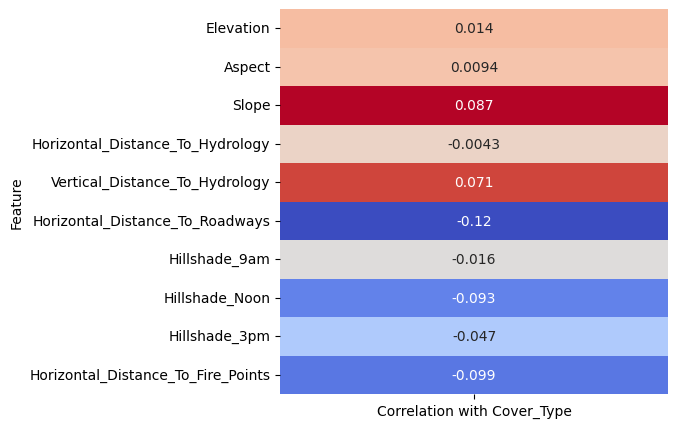

In [3]:
# Get qualitative features names
qualitative_columns = [col for col in df_train.columns if col.startswith('Soil_Type') or col.startswith('Wilderness_Area')]

# confusion matrix between Cover_type and every quantitative feature 
confusion_matrix = []
for col in df_train.columns:
    if col not in qualitative_columns and col != 'Cover_Type':
        confusion_matrix.append([col, df_train['Cover_Type'].corr(df_train[col])])
        
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Feature', 'Correlation with Cover_Type'])
confusion_matrix_df.set_index('Feature', inplace=True)

# plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix_df, annot=True, cmap='coolwarm', cbar=False)
plt.show()

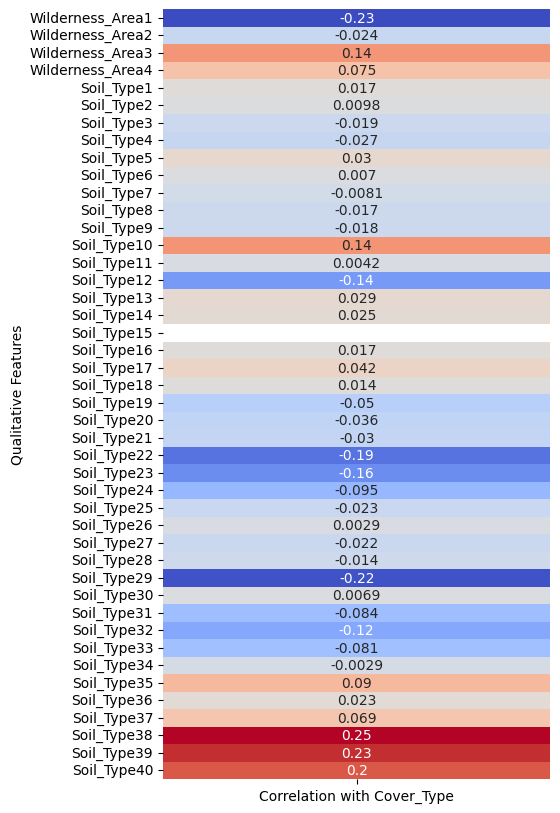

Qualitative Features
Soil_Type38         0.254248
Soil_Type39         0.234777
Wilderness_Area1    0.229981
Soil_Type29         0.221978
Soil_Type40         0.199545
Soil_Type22         0.185038
Soil_Type23         0.155529
Soil_Type10         0.140102
Soil_Type12         0.138125
Wilderness_Area3    0.137298
Name: Correlation with Cover_Type, dtype: float64


In [4]:
# confusion matrix between Cover_type and every qualitative feature 
confusion_matrix = []
for col in qualitative_columns:
    confusion_matrix.append([col, df_train['Cover_Type'].corr(df_train[col])])
        
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Qualitative Features', 'Correlation with Cover_Type'])
confusion_matrix_df.set_index('Qualitative Features', inplace=True)

# plot confusion matrix
plt.figure(figsize=(5, 10))
sns.heatmap(confusion_matrix_df, annot=True, cmap='coolwarm', cbar=False)
plt.show()

# print 10 most correlated features
print(confusion_matrix_df['Correlation with Cover_Type'].abs().sort_values(ascending=False).head(10))

In [33]:
df_train.describe()

Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2748.649934    155.834524     16.556746   
std      419.009589    109.745372      8.534602   
min     1877.000000      0.000000      0.000000   
25%     2373.000000     65.000000     10.000000   
50%     2754.000000    125.000000     15.000000   
75%     3109.000000    257.000000     22.000000   
max     3850.000000    360.000000     50.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         228.376521                       51.311706   
std                          209.196381                       61.520488   
min                            0.000000                     -135.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       80.000000   
max                         1376.000000                      570.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1717.977712     213.028836      218.865741   
std                        1330.263450      30.638406       22.797288   
min                           0.000000      52.000000       99.000000   
25%                         760.000000     197.000000      207.000000   
50%                        1315.000000     220.000000      223.000000   
75%                        2292.000000     236.000000      235.000000   
max                        6803.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  ...   Soil_Type32  \
count   15120.000000                        15120.000000  ...  15120.000000   
mean      134.477116                         1527.357804  ...      0.043849   
std        46.070054                         1116.636997  ...      0.204766   
min         0.000000                            0.000000  ...      0.000000   
25%       106.000000                          750.000000  ...      0.000000   
50%       138.000000                         1266.000000  ...      0.000000   
75%       166.000000                         2002.000000  ...      0.000000   
max       251.000000                         7095.000000  ...      1.000000   

        Soil_Type33   Soil_Type34   Soil_Type35   Soil_Type36   Soil_Type37  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.040939      0.001190      0.006812      0.000926      0.002116   
std        0.198156      0.034484      0.082257      0.030416      0.045957   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type38   Soil_Type39   Soil_Type40    Cover_Type  
count  15120.000000  15120.000000  15120.000000  15120.000000  
mean       0.049206      0.041931      0.030159      4.000000  
std        0.216306      0.200439      0.171030      2.000066  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.000000      0.000000      0.000000      2.000000  
50%        0.000000      0.000000      0.000000      4.000000  
75%        0.000000      0.000000      0.000000      6.000000  
max        1.000000      1.000000      1.000000      7.000000  

[8 rows x 55 columns]

In [4]:
quantitative_columns = [col for col in df_train.columns if col not in qualitative_columns and col != 'Cover_Type']

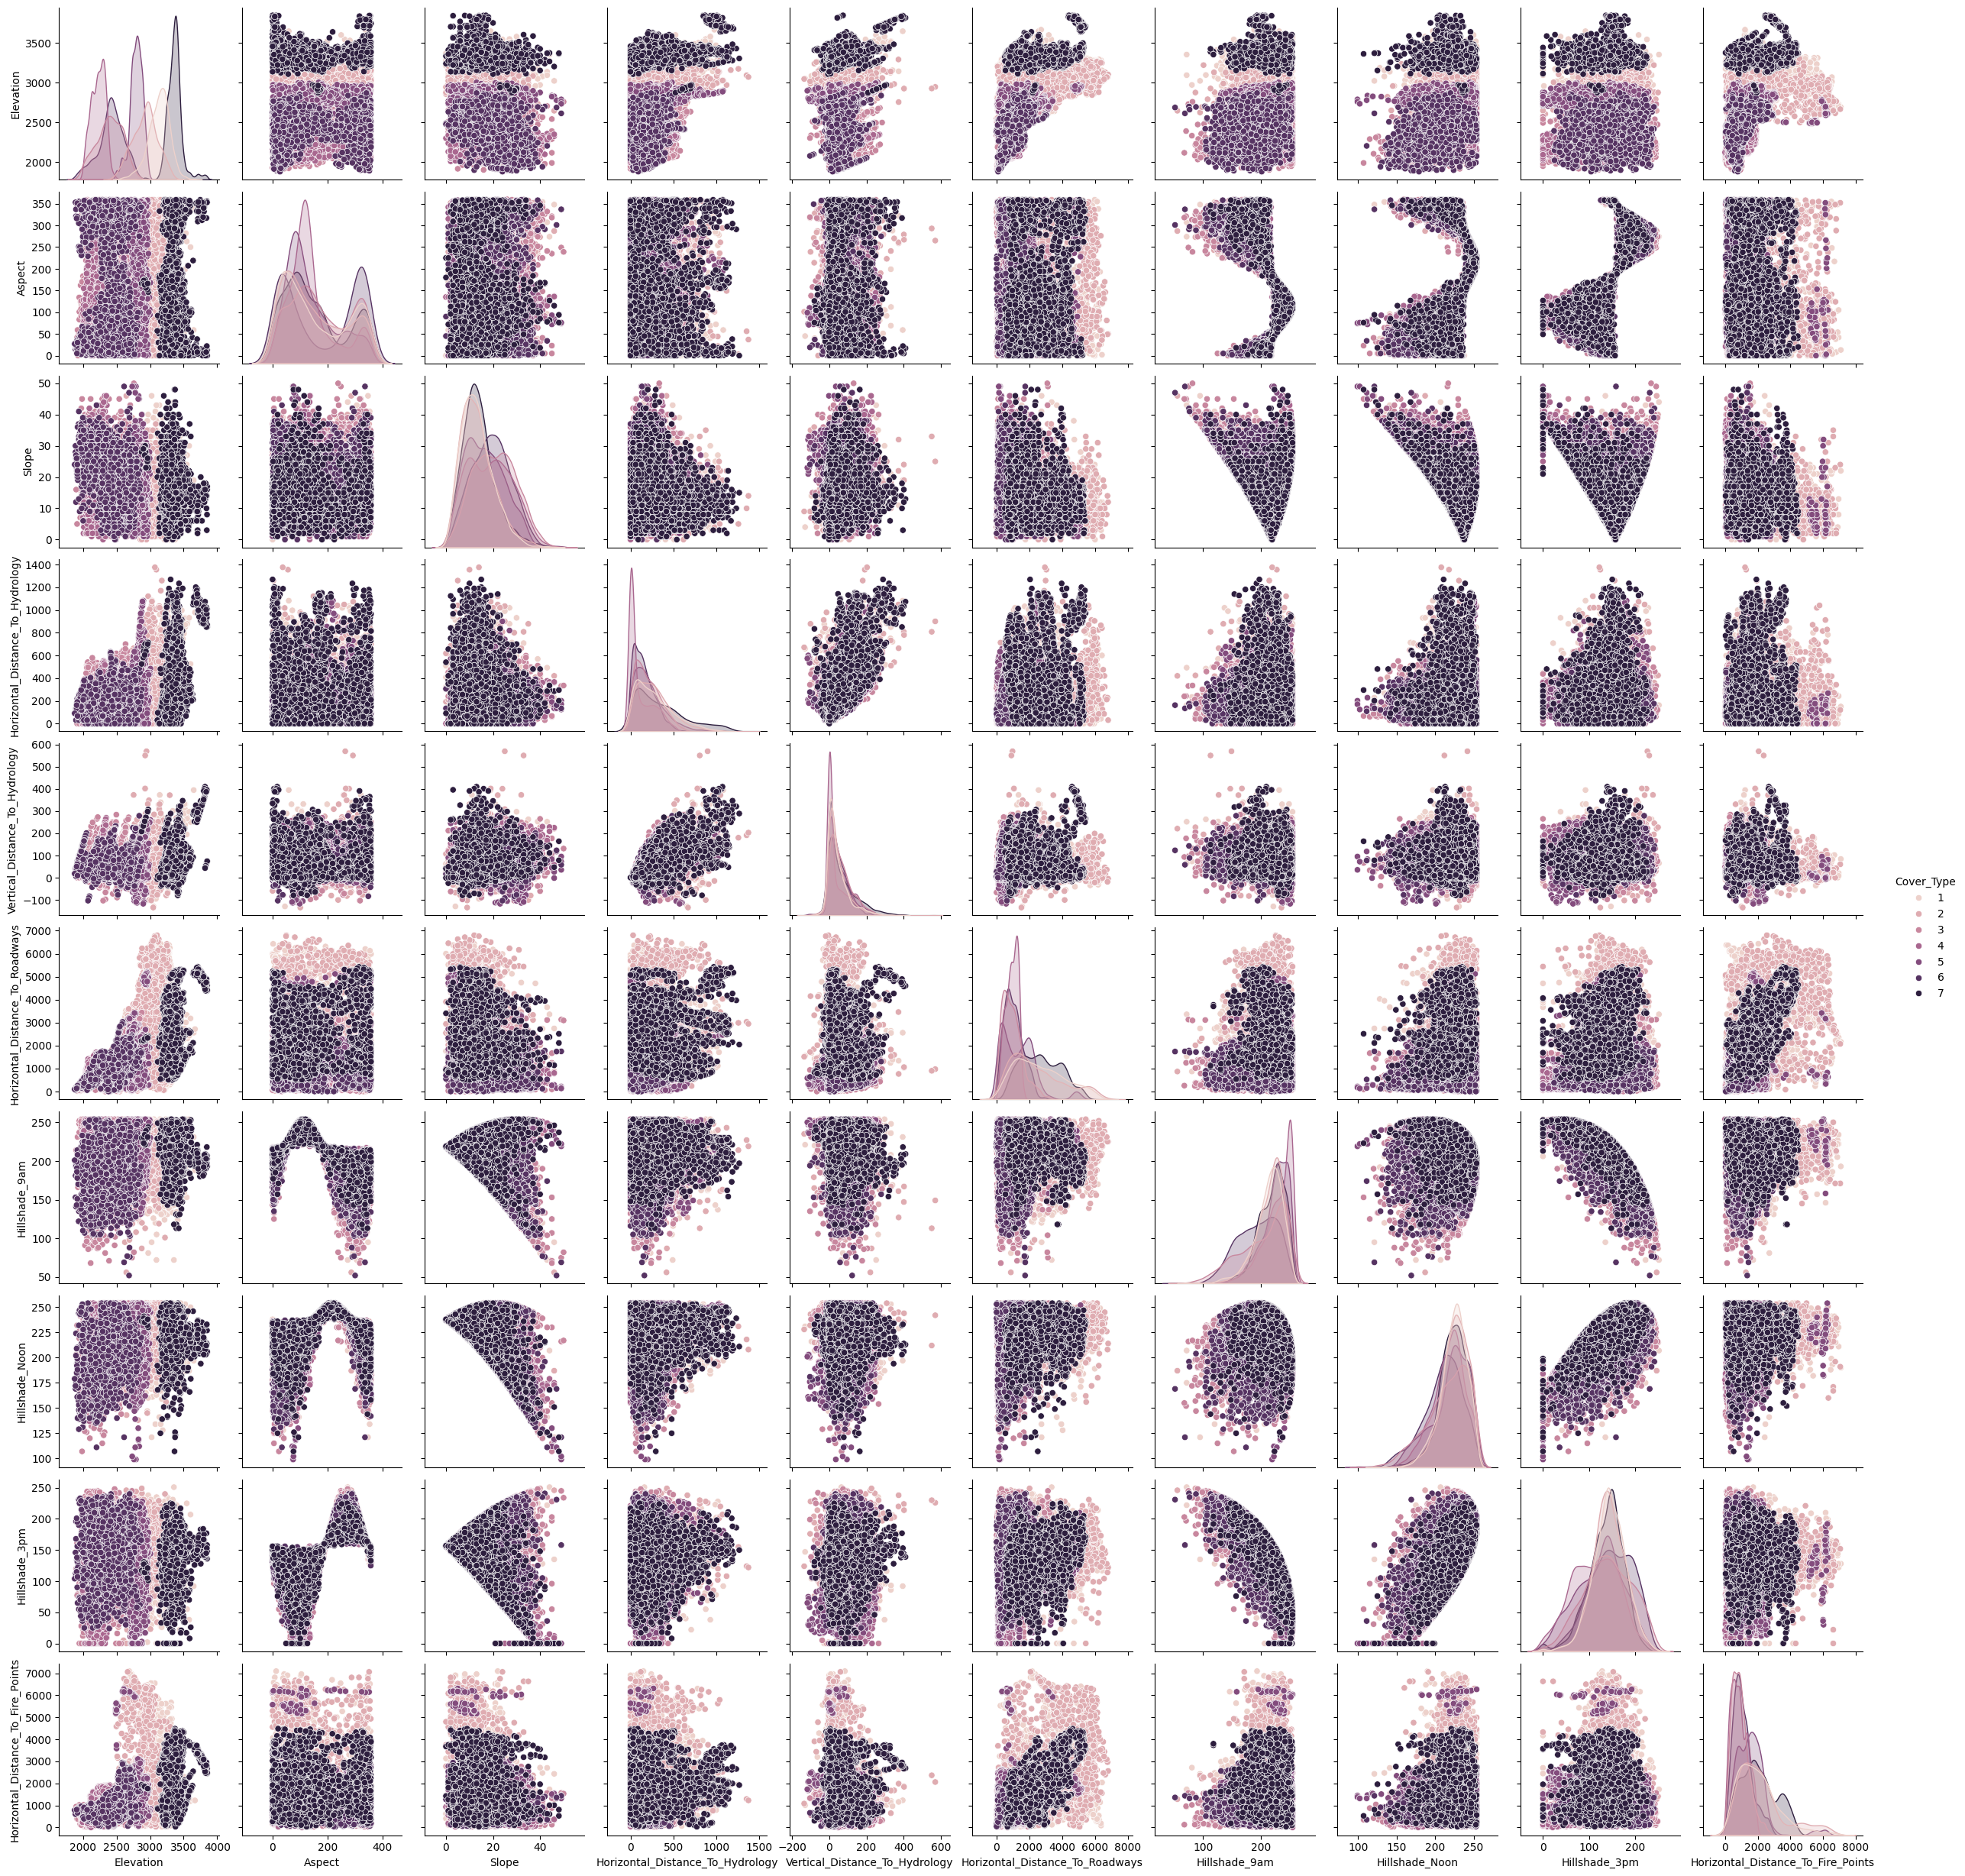

In [6]:
sns.pairplot(df_train[quantitative_columns + ['Cover_Type']], hue='Cover_Type')

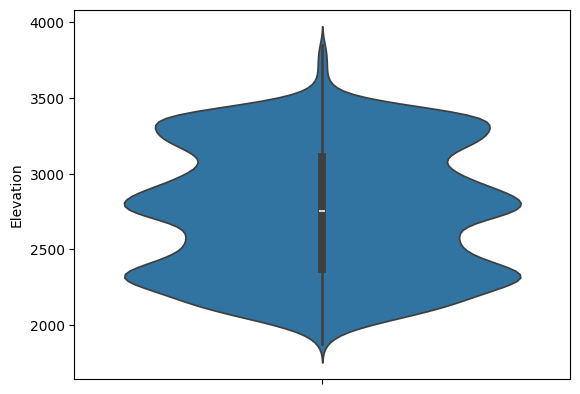

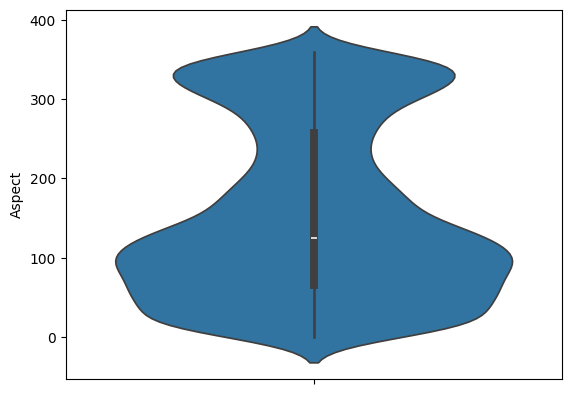

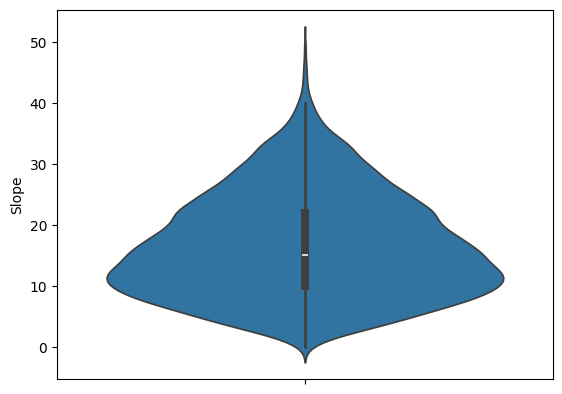

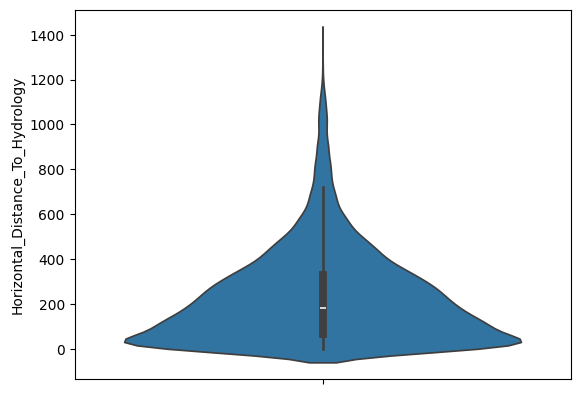

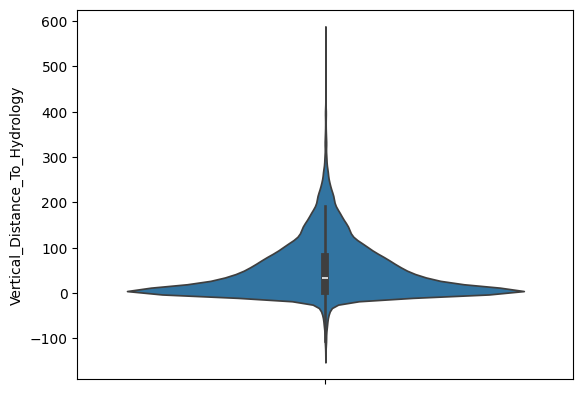

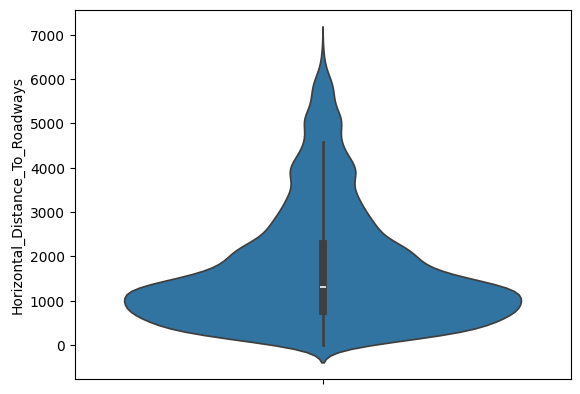

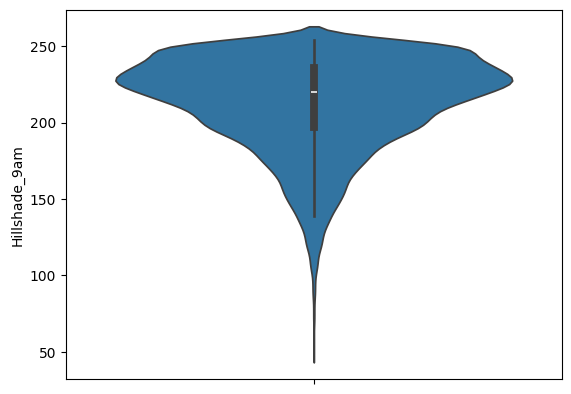

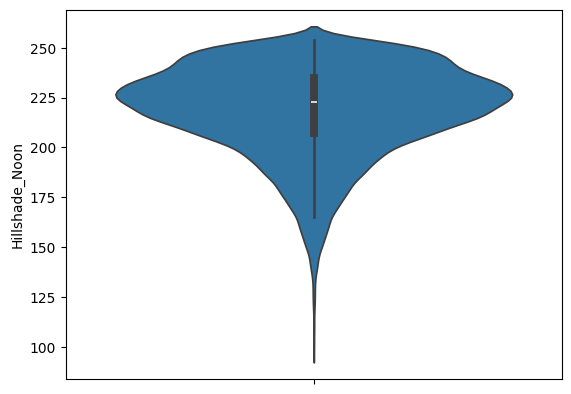

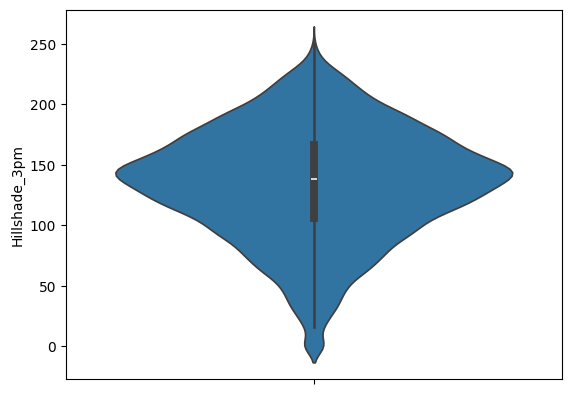

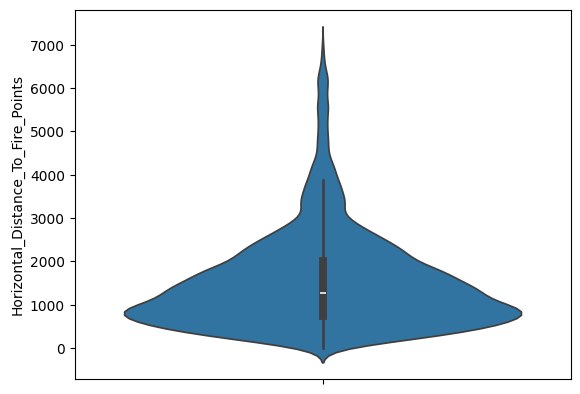

In [8]:
for col in quantitative_columns:
    sns.violinplot(df_train[col])
    plt.show()

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Chi-Squared test for feature selection 

scaler = MinMaxScaler()

# chi2 test requires non-negative values
x_train_scaled = scaler.fit_transform(x_train)
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_train_scaled, y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.columns)  # Use original x_train for column names

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']  # Naming the dataframe columns

print(featureScores.nlargest(30, 'Score'))

                               Feature        Score
13                    Wilderness_Area4  6978.498184
23                         Soil_Type10  3786.137405
16                          Soil_Type3  3684.000000
51                         Soil_Type38  3281.696237
10                    Wilderness_Area1  3080.395179
52                         Soil_Type39  2823.580442
53                         Soil_Type40  2028.355263
43                         Soil_Type30  1868.342391
42                         Soil_Type29  1615.998471
12                    Wilderness_Area3  1343.197398
0                            Elevation  1337.497304
25                         Soil_Type12  1266.484615
17                          Soil_Type4  1201.804529
35                         Soil_Type22  1084.993976
30                         Soil_Type17  1027.968750
11                    Wilderness_Area2   961.441125
26                         Soil_Type13   950.272904
19                          Soil_Type6   928.144330
36          

# Feature Engineering
Given that certain soil types have an associated ELU code that coresponds to a certain geographical area that could be indicative of Cover_Type 

In [25]:
# Mapping of Soil Types to ELU Codes
elu_codes = {
    1: '2702', 2: '2703', 3: '2704', 4: '2705', 5: '2706', 6: '2717', 7: '3501', 8: '3502', 9: '4201', 10: '4703',
    11: '4704', 12: '4744', 13: '4758', 14: '5101', 15: '5151', 16: '6101', 17: '6102', 18: '6731', 19: '7101', 20: '7102',
    21: '7103', 22: '7201', 23: '7202', 24: '7700', 25: '7701', 26: '7702', 27: '7709', 28: '7710', 29: '7745', 30: '7746',
    31: '7755', 32: '7756', 33: '7757', 34: '7790', 35: '8703', 36: '8707', 37: '8708', 38: '8771', 39: '8772', 40: '8776'
}

# Function to extract climatic and geologic zone information
def extract_zones(elu_code):
    climatic_zone = elu_code[0]
    geologic_zone = elu_code[1]
    return climatic_zone, geologic_zone

# Create new database with climatic and geologic zones one hot encoded instead of Soil_Type
df_train_zones = df_train.copy()
df_test_zones = df_test.copy()

for i in range(1, 41):
    climatic_zone, geologic_zone = extract_zones(elu_codes[i])
    df_train_zones[f'climatic_zone_{climatic_zone}'] = df_train_zones[f'Soil_Type{i}']
    df_train_zones[f'geologic_zone_{geologic_zone}'] = df_train_zones[f'Soil_Type{i}']
    df_test_zones[f'climatic_zone_{climatic_zone}'] = df_test_zones[f'Soil_Type{i}']
    df_test_zones[f'geologic_zone_{geologic_zone}'] = df_test_zones[f'Soil_Type{i}']
    
# remove Soil_Type columns
# df_train_zones = df_train_zones.drop([f'Soil_Type{i}' for i in range(1, 41)], axis=1)


In [22]:
zones_columns = [col for col in df_train_zones.columns if col.startswith('climatic_zone') or col.startswith('geologic_zone')]

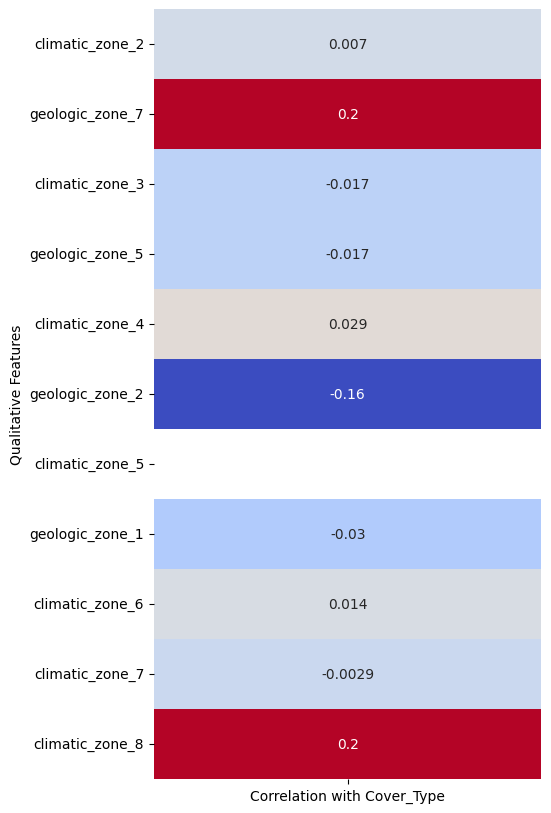

Qualitative Features
geologic_zone_7    0.199545
climatic_zone_8    0.199545
geologic_zone_2    0.155529
geologic_zone_1    0.029585
climatic_zone_4    0.028677
climatic_zone_3    0.017253
geologic_zone_5    0.017253
climatic_zone_6    0.014120
climatic_zone_2    0.007026
climatic_zone_7    0.002877
Name: Correlation with Cover_Type, dtype: float64


In [23]:
# confusion matrix between Cover_type and every qualitative feature 
confusion_matrix = []
for col in zones_columns:
    confusion_matrix.append([col, df_train_zones['Cover_Type'].corr(df_train_zones[col])])
        
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Qualitative Features', 'Correlation with Cover_Type'])
confusion_matrix_df.set_index('Qualitative Features', inplace=True)

# plot confusion matrix
plt.figure(figsize=(5, 10))
sns.heatmap(confusion_matrix_df, annot=True, cmap='coolwarm', cbar=False)
plt.show()

# print 10 most correlated features
print(confusion_matrix_df['Correlation with Cover_Type'].abs().sort_values(ascending=False).head(10))

# Train model
## Naive XGboost

In [9]:
#training model

xgbc = xgb.XGBClassifier()
xgbc.fit(x_train, y_train)

#establishing baseline with no hyper-parameter optimisation or feature engineering

scores = cross_val_score(xgbc, x_train, y_train)
print(mean(scores))

0.8552248677248677


In [10]:
#random grid search CV
learning_rate = []
n_estimators = []
subsample = []
colsample_bytree = []
gamma = []
for i in range(100, 1000):
    learning_rate.append(uniform(0.01, 0.1))
    n_estimators.append(i)
    subsample.append(uniform(0.5, 0.5))
    colsample_bytree.append(uniform(0.5, 0.5))
    gamma.append(uniform(0, 0.5))

param_dist = {'max_depth' : [9, 10, 11, 12],
    'learning_rate' : uniform(0.01, 0.1),
    'n_estimators' : randint(100, 1000),
    'subsample' : uniform(0.5, 0.5),
    'colsample_bytree' : uniform(0, 0.5),
    'gamma' : uniform(0, 0.5)}

random_search = RandomizedSearchCV(xgbc, param_distributions = param_dist, n_iter = 10, cv=5, verbose=1, n_jobs=1)

random_search.fit(x_train, y_train)

print(random_search.best_params_)

best_xgbc = random_search.best_estimator_
scores = cross_val_score(best_xgbc, x_train, y_train)
print(mean(scores))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'colsample_bytree': 0.4067915549255939, 'gamma': 0.22694958985961006, 'learning_rate': 0.07654195293796065, 'max_depth': 11, 'n_estimators': 149, 'subsample': 0.5914424487299136}
0.853505291005291


In [56]:
print(random_search.best_params_)

{'colsample_bytree': 0.41938125697148076, 'gamma': 0.15632948894043341, 'learning_rate': 0.02465570471755834, 'max_depth': 10, 'n_estimators': 601, 'subsample': 0.8909036136371465}


In [11]:
y_pred = best_xgbc.predict(df_test)
df_test['Cover_Type'] = y_pred + 1
df_test

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0            2596      51      3                               258   
1            2590      56      2                               212   
2            2804     139      9                               268   
3            2785     155     18                               242   
4            2595      45      2                               153   
...           ...     ...    ...                               ...   
581007       2396     153     20                                85   
581008       2391     152     19                                67   
581009       2386     159     17                                60   
581010       2384     170     15                                60   
581011       2383     165     13                                60   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                    0                              510   
1                                   -6                              390   
2                                   65                             3180   
3                                  118                             3090   
4                                   -1                              391   
...                                ...                              ...   
581007                              17                              108   
581008                              12                               95   
581009                               7                               90   
581010                               5                               90   
581011                               4                               67   

        Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                 221             232            148   
1                 220             235            151   
2                 234             238            135   
3                 238             238            122   
4                 220             234            150   
...               ...             ...            ...   
581007            240             237            118   
581008            240             237            119   
581009            236             241            130   
581010            230             245            143   
581011            231             244            141   

        Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                     6279  ...            0            0   
1                                     6225  ...            0            0   
2                                     6121  ...            0            0   
3                                     6211  ...            0            0   
4                                     6172  ...            0            0   
...                                    ...  ...          ...          ...   
581007                                 837  ...            0            0   
581008                                 845  ...            0            0   
581009                                 854  ...            0            0   
581010                                 864  ...            0            0   
581011                                 875  ...            0            0   

        Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0                 0            0            0            0            0   
1                 0            0            0            0            0   
2                 0            0            0            0            0   
3                 0            0            0            0            0   
4                 0            0            0            0            0   
...             ...          ...          ...          ...          ...   
581007            0            0            0            0            0   
581008            0            0            0            0          

## Random Tree

In [27]:
print("shape of test set: ", df_test_zones.shape)
print("shape of train set: ", df_train_zones.shape)

shape of test set:  (581012, 65)
shape of train set:  (15120, 66)


In [35]:
# split df_train_zones into test and train
from sklearn.model_selection import train_test_split
X = df_train_zones.drop(['Cover_Type'], axis=1)
y = df_train_zones['Cover_Type']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# implement random tree with grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [500, 800, 1000, 1200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [8,9,10],
    'criterion' :['entropy', 'gini', 'mse', 'mae']
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_rfc = grid_search.best_estimator_
print(best_rfc)
y_pred = best_rfc.predict(x_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))

C:\Users\Gaspard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gaspard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gaspard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=800)
Accuracy score:  0.8009259259259259


In [39]:
best_params = grid_search.best_params_
print("Best criterion:", best_params)

Best criterion: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 800}


In [41]:
from sklearn.metrics import accuracy_score

# Predict the labels of the test set
y_pred = best_rfc.predict(x_test)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)

Accuracy: 0.8009259259259259


## Neural network

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df_train_zones.drop(['Cover_Type'], axis=1)
y = df_train_zones['Cover_Type']
y = y - 1
X = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Create 4 dense layers with 100, 50, 25 and 10 neurons 

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(100, input_shape=(x_train.shape[1],), activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/100
378/378 [==============================] - 6s 9ms/step - loss: 0.9441 - accuracy: 0.6194 - val_loss: 0.7499 - val_accuracy: 0.6918
Epoch 2/100
378/378 [==============================] - 3s 9ms/step - loss: 0.7131 - accuracy: 0.6978 - val_loss: 0.6685 - val_accuracy: 0.7169
Epoch 3/100
378/378 [==============================] - 3s 8ms/step - loss: 0.6512 - accuracy: 0.7221 - val_loss: 0.6487 - val_accuracy: 0.7315
Epoch 4/100
378/378 [==============================] - 3s 9ms/step - loss: 0.6195 - accuracy: 0.7383 - val_loss: 0.6117 - val_accuracy: 0.7447
Epoch 5/100
378/378 [==============================] - 4s 10ms/step - loss: 0.5868 - accuracy: 0.7551 - val_loss: 0.5771 - val_accuracy: 0.7586
Epoch 6/100
378/378 [==============================] - 3s 9ms/step - loss: 0.5678 - accuracy: 0.7585 - val_loss: 0.5838 - val_accuracy: 0.7490
Epoch 7/100
378/378 [==============================] - 3s 7ms/step - loss: 0.5508 - accuracy: 0.7643 - val_loss: 0.5640 - val_accuracy: 0.765

In [57]:
# get score of model
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

95/95 [==============================] - 0s 4ms/step - loss: 0.5047 - accuracy: 0.8320
Test loss: 0.8320105671882629


# Submit file 

In [90]:
df_submission = pd.DataFrame({'Id': x_test['Id'].values, 'Cover_Type' : df_test['Cover_Type'].values})
df_submission['Cover_Type'].unique()

array([5, 2, 1, 7, 6, 3, 4], dtype=int64)

In [91]:
df_submission

Id  Cover_Type
0            1           5
1            2           5
2            3           2
3            4           2
4            5           5
...        ...         ...
581007  581008           3
581008  581009           3
581009  581010           3
581010  581011           3
581011  581012           3

[581012 rows x 2 columns]

In [92]:
df_submission.to_csv('full_submission.csv', index = False)

In [93]:
submission_file = pd.read_csv('full_submission.csv')

In [80]:
submission_file

Cover_Type      Id
0                5       1
1                5       2
2                2       3
3                5       4
4                5       5
...            ...     ...
581007           3  581008
581008           3  581009
581009           3  581010
581010           3  581011
581011           3  581012

[581012 rows x 2 columns]